# Setup

In [1]:
try:
    import google.colab # type: ignore
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

In [2]:
if IN_COLAB:
    !pip install -q scikit-learn
    !pip install -q einops jaxtyping
    !pip install -q transformers tokenizers
    !pip install -q transformer_lens circuitsvis

In [3]:
from dataclasses import dataclass
import random
import gc
from pathlib import Path
import functools

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

import torch as t
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import einops
from tqdm.notebook import tqdm #progress bars
from typing import Tuple, List, Optional, Dict
from jaxtyping import Float, Int, Bool
from torch import Tensor

from transformer_lens.hook_points import HookPoint
from transformer_lens import utils, HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
from transformers import PreTrainedTokenizer, PreTrainedTokenizerFast

import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import clear_output
import circuitsvis as cv

import h5py
import palettable

device = t.device("cuda" if t.cuda.is_available() else "cpu")
if IN_COLAB:
    rootdir=Path('/content/drive/MyDrive/AI/plusminus/')
    traindir = rootdir/'trained_models/'
else:
    rootdir=Path('./')
    traindir=rootdir/'training_data/'
figdir = rootdir/'figures/'
print('using device: ', device)
print('rootdir is: ', rootdir)

using device:  cpu
rootdir is:  .


# Tokenizer

In [4]:
tokenizer = PreTrainedTokenizerFast(tokenizer_file=str(traindir/'tokenizer_2digit.json'), add_bos_token=True, name_or_path='2digit')
vocab = tokenizer.get_vocab()

# Model

In [5]:
@dataclass
class Config():
  d_vocab: int = len(tokenizer.get_vocab().keys())
  d_model: int = len(tokenizer.get_vocab().keys())
  d_mlp: int = 72
  n_heads: int = 8
  d_head: int = 18
  n_ctx: int = 6 #(N)(-)(N)(=)(+/-)(N)
  n_layers: int = 1

def build_hooked_transformer(cfg: Config, attn_only=False, one_hot_encode=True, norm_type='LN', **kwargs):

    hkconfig = HookedTransformerConfig(
        n_layers = cfg.n_layers,
        d_model = cfg.d_model,
        n_ctx = cfg.n_ctx,
        d_head = cfg.d_head,
        n_heads = cfg.n_heads,
        act_fn = 'relu',
        attn_only=attn_only,
        normalization_type=norm_type,
        **kwargs
    )
    model =  HookedTransformer(cfg = hkconfig, tokenizer=tokenizer)

    if attn_only:
        #Remove biases from attention heads for direct comparison with math framework paper.
        for layer in model.blocks:
            layer.attn.b_K.requires_grad = False
            layer.attn.b_O.requires_grad = False
            layer.attn.b_Q.requires_grad = False
            layer.attn.b_V.requires_grad = False

    if one_hot_encode:
        if cfg.d_model != len(tokenizer.get_vocab().keys()):
            raise ValueError("d_model != d_vocab, but that is required for one-hot encoding.")
        model.embed.W_E.requires_grad = False
        model.embed.W_E[:] = t.eye(cfg.d_model, cfg.d_model)
        model.unembed.W_U.requires_grad = False
        model.unembed.b_U.requires_grad = False
        model.unembed.W_U[:] = t.eye(cfg.d_model, cfg.d_model)
    return model

In [6]:
# Model Config
d_vocab = len(tokenizer.get_vocab().keys())
d_model = 128
n_head = 4
d_head = d_model // n_head
d_mlp  = 4 * d_model
n_layers = 1
attn_only = False
one_hot_encode = False
cfg = Config(n_layers=n_layers, d_model=d_model, n_heads=n_head, d_mlp=d_mlp, d_head=d_head)

# Load Model
tfm = build_hooked_transformer(cfg, attn_only=attn_only, one_hot_encode=one_hot_encode, norm_type=None)
tfm.to(device)
tokenizer = tfm.tokenizer
filename = traindir/'mlp_2digit_subtraction_nlayer1_nheads4_dmodel128_dhead32_seed12466689936998274052.pt'
tfm.load_state_dict(t.load(filename, map_location=device))

Moving model to device:  cpu


<All keys matched successfully>

In [7]:
# It's good to define helper variables
W_O = tfm.W_O[0]
W_K = tfm.W_K[0]
W_Q = tfm.W_Q[0]
W_V = tfm.W_V[0]
W_in = tfm.W_in[0]
W_out = tfm.W_out[0]
W_pos = tfm.W_pos
W_E = tfm.W_E
W_U = tfm.W_U

print('W_O  ', tuple(W_O.shape))
print('W_K  ', tuple(W_K.shape))
print('W_Q  ', tuple(W_Q.shape))
print('W_V  ', tuple(W_V.shape))
print('W_in ', tuple(W_in.shape))
print('W_out', tuple(W_out.shape))
print('W_pos', tuple(W_pos.shape))
print('W_E  ', tuple(W_E.shape))
print('W_U  ', tuple(W_U.shape))

W_O   (4, 32, 128)
W_K   (4, 128, 32)
W_Q   (4, 128, 32)
W_V   (4, 128, 32)
W_in  (128, 512)
W_out (512, 128)
W_pos (6, 128)
W_E   (103, 128)
W_U   (128, 103)


In [8]:
W_E_inv = t.Tensor(np.linalg.pinv(W_E.detach().numpy()))
print(W_E_inv@W_E)

tensor([[ 0.9560,  0.0467,  0.0084,  ..., -0.0189, -0.0045, -0.0137],
        [ 0.0467,  0.6950,  0.0693,  ..., -0.0012,  0.0206,  0.0223],
        [ 0.0084,  0.0693,  0.9281,  ...,  0.0232,  0.0050,  0.0049],
        ...,
        [-0.0189, -0.0012,  0.0232,  ...,  0.9425,  0.0053, -0.0093],
        [-0.0045,  0.0206,  0.0050,  ...,  0.0053,  0.9863, -0.0031],
        [-0.0137,  0.0223,  0.0049,  ..., -0.0093, -0.0031,  0.9768]],
       grad_fn=<MmBackward0>)


# Data

In [9]:
class DataHolder:

    def __init__(self, train_frac=0.3, batch_size=128):

        data = self.get_dataset()
        self.strs = self.build_strings(data)
        self.tok = self.encode(self.strs)

    def get_dataset(self):
        data = t.Tensor([(i,j) for i in range(100) for j in range(100)])
        results = data[:,:1] - data[:,-1:]
        return t.cat((data, results), dim=1).to(t.int64)

    def build_strings(self, nums: Tensor):
        iterable = zip(nums[:,0], nums[:,1], nums[:,2])
        data = [f'{n1}-{n2}={res:+d}' for n1,n2,res in iterable]
        return data

    def encode(self, str_data):
        return t.Tensor(tokenizer.batch_encode_plus(str_data).input_ids).to(t.int64)

data = DataHolder()
print(data.strs[:10])
print(data.strs[::333], data.tok[::333])

['0-0=+0', '0-1=-1', '0-2=-2', '0-3=-3', '0-4=-4', '0-5=-5', '0-6=-6', '0-7=-7', '0-8=-8', '0-9=-9']
['0-0=+0', '3-33=-30', '6-66=-60', '9-99=-90', '13-32=-19', '16-65=-49', '19-98=-79', '23-31=-8', '26-64=-38', '29-97=-68', '33-30=+3', '36-63=-27', '39-96=-57', '43-29=+14', '46-62=-16', '49-95=-46', '53-28=+25', '56-61=-5', '59-94=-35', '63-27=+36', '66-60=+6', '69-93=-24', '73-26=+47', '76-59=+17', '79-92=-13', '83-25=+58', '86-58=+28', '89-91=-2', '93-24=+69', '96-57=+39', '99-90=+9'] tensor([[  0, 101,   0, 102, 100,   0],
        [  3, 101,  33, 102, 101,  30],
        [  6, 101,  66, 102, 101,  60],
        [  9, 101,  99, 102, 101,  90],
        [ 13, 101,  32, 102, 101,  19],
        [ 16, 101,  65, 102, 101,  49],
        [ 19, 101,  98, 102, 101,  79],
        [ 23, 101,  31, 102, 101,   8],
        [ 26, 101,  64, 102, 101,  38],
        [ 29, 101,  97, 102, 101,  68],
        [ 33, 101,  30, 102, 100,   3],
        [ 36, 101,  63, 102, 101,  27],
        [ 39, 101,  96, 102

# Baseline model performance

In [10]:
def get_accuracy(
    logits: Float[Tensor, "batch posn d_vocab"],
    tokens: Int[Tensor, "batch posn"],
    meandim: int = None
) -> Float[Tensor, "batch posn-1"]:

    logit_preds = logits[:, 3:-1, :].argmax(dim=-1) #5-digit
    acc = (logit_preds == tokens[:, 4:]).to(t.float)
    return acc.mean(dim=meandim)

def get_loss(
    logits: Float[Tensor, "batch posn d_vocab"],
    tokens: Int[Tensor, "batch posn"],
    meandim: int = None
) -> Float[Tensor, "batch posn-1"]:

    log_probs = logits.log_softmax(dim=-1)
    # Get logprobs the first seq_len-1 predictions (so we can compare them with the actual next tokens)
    log_probs_for_tokens = log_probs[:, 3:-1].gather(dim=-1, index=tokens[:, 4:].unsqueeze(-1)).squeeze(-1) #5-digit
    return -log_probs_for_tokens.mean(dim=meandim)


In [11]:
original_logits, cache = tfm.run_with_cache(data.tok)
# Final 2 positions: (+/-) and number. Also remove the logits for `=`
original_loss = get_loss(original_logits, data.tok, meandim=0) #loss by digit
original_acc  = get_accuracy(original_logits, data.tok, meandim=0)
original_logits = original_logits[:, -2:, :-1]
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")

Original loss: [0.06826338 0.01807366], Original acc: [98.549995 99.94    ]%


In [12]:
def approx_posembed_hook(
    embedding: Float[Tensor, "batch seq d_model"],
    hook: HookPoint,
) -> Float[Tensor, "batch seq d_model"]:
    embedding[:,:,:] = (einops.einsum(W_E_inv, W_E, W_pos, 'model vocab, vocab imodel, seq imodel -> seq model'))[None,:]


ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("pos_embed"), approx_posembed_hook)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('Approximating positional embed]')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")


Approximating positional embed]
Original loss: [0.06826338 0.01807366], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.06848554 0.01810081], Ablated acc: [98.549995 99.94    ]%


# Training dynamics

In [13]:
with h5py.File(traindir/'dynamics_mlp_2digit_subtraction_nlayer1_nheads4_dmodel128_dhead32_seed12466689936998274052.h5', 'r') as f:
    model_seed = f['model_seed'][()]
    data_seed = f['data_seed'][()]
    iters = f['iters'][()]
    train_losses = f['train_losses'][()]
    valid_losses = f['valid_losses'][()]
    train_accuracies = f['train_accuracies'][()]
    valid_accuracies = f['valid_accuracies'][()]

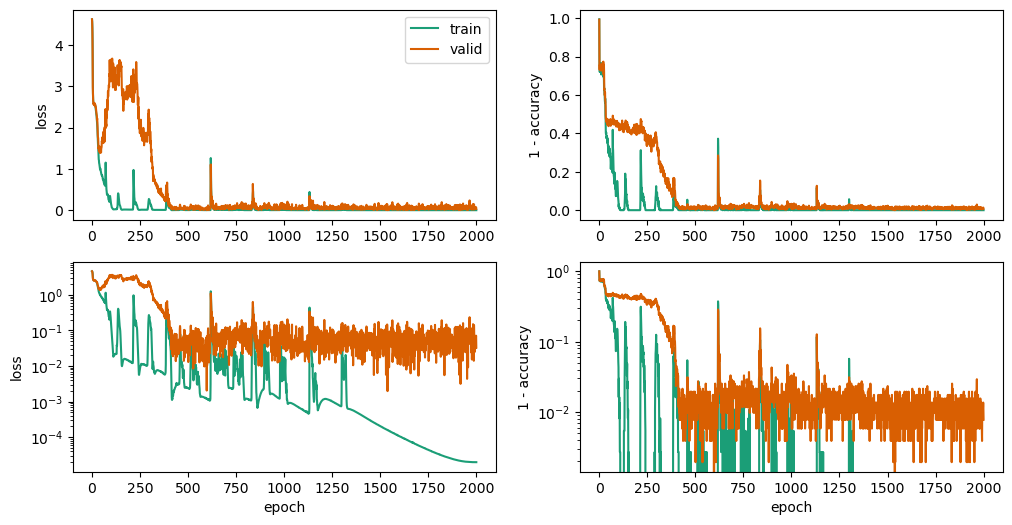

In [14]:
fig, axs = plt.subplots(2,2, figsize=(12, 6))
for i in range(2):
    for j in range(2):
        axs[i][j].set_prop_cycle('color', palettable.colorbrewer.qualitative.Dark2_8.mpl_colors)

axs[0][0].plot(iters, train_losses, label='train')
axs[0][0].plot(iters, valid_losses, label='valid')
axs[1][0].semilogy(iters, train_losses)
axs[1][0].semilogy(iters, valid_losses)
axs[0][0].set_ylabel('loss')
axs[1][0].set_ylabel('loss')
axs[0][0].legend()

axs[0][1].plot(iters, 1-train_accuracies)
axs[0][1].plot(iters, 1-valid_accuracies)
axs[1][1].semilogy(iters, 1-train_accuracies)
axs[1][1].semilogy(iters, 1-valid_accuracies)
axs[0][1].set_ylabel('1 - accuracy')
axs[1][1].set_ylabel('1 - accuracy')

axs[1][0].set_xlabel('epoch')
axs[1][1].set_xlabel('epoch')

fig.savefig(figdir/'training_dynamics.png', dpi=300, bbox_inches='tight')

# Matrix Periodicity

<>:18: SyntaxWarning: invalid escape sequence '\p'
<>:19: SyntaxWarning: invalid escape sequence '\p'
<>:18: SyntaxWarning: invalid escape sequence '\p'
<>:19: SyntaxWarning: invalid escape sequence '\p'
/var/folders/ry/qny1f95136l2lpppg_d78n6c0000gn/T/ipykernel_75394/2562311580.py:18: SyntaxWarning: invalid escape sequence '\p'
  axs[0].text(0.98, 0.98, f'Embed ($\pm${W_E.abs().max().item()/2:.3f})', ha='right', va='top', bbox=bbox_props, transform=axs[0].transAxes)
/var/folders/ry/qny1f95136l2lpppg_d78n6c0000gn/T/ipykernel_75394/2562311580.py:19: SyntaxWarning: invalid escape sequence '\p'
  axs[1].text(0.98, 0.98, f'Unembed ($\pm${W_U.abs().max().item():.3f}', ha='right', va='top', bbox=bbox_props, transform=axs[1].transAxes)


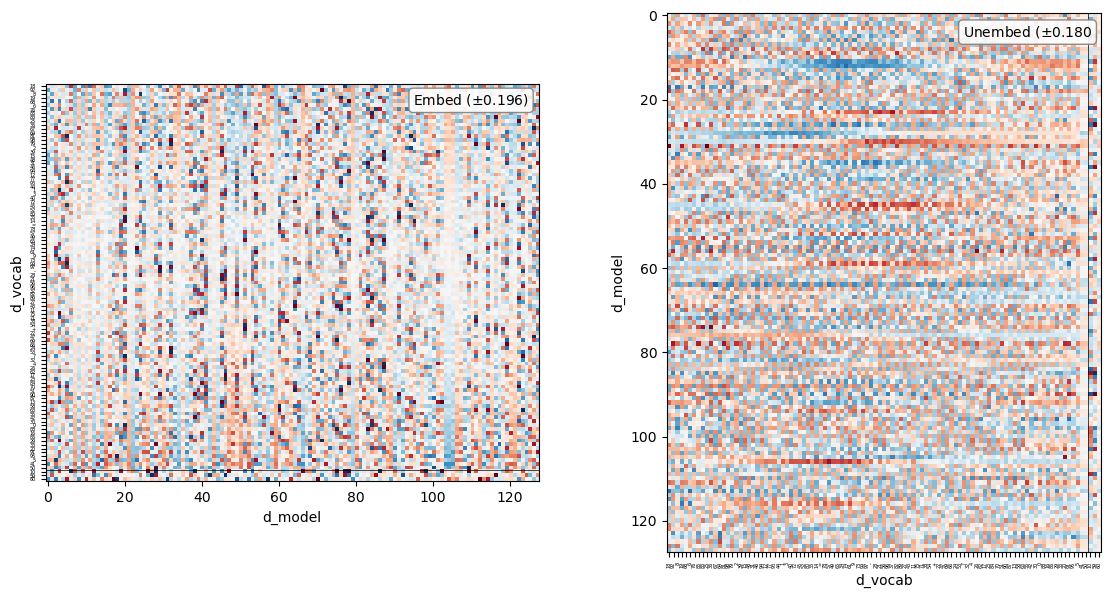

In [15]:
fig, axs = plt.subplots(1,2, figsize=(14, 7))
axs[0].imshow(W_E.detach().numpy(), cmap='RdBu_r', vmax=W_E.abs().max().item()/2, vmin=-W_E.abs().max().item()/2, rasterized=True)
axs[0].axhline(99.5, c='k', lw=0.5)
axs[0].set_ylabel('d_vocab')
axs[0].set_xlabel('d_model')
axs[0].set_yticks(range(d_vocab));
axs[0].set_yticklabels(vocab, fontsize=3.5);

axs[1].imshow(tfm.W_U.detach().numpy(), cmap='RdBu_r', vmax=W_U.abs().max().item(), vmin=-W_U.abs().max().item(), rasterized=True)
axs[1].axvline(99.5, c='k', lw=0.5)
axs[1].set_xlabel('d_vocab')
axs[1].set_ylabel('d_model')
axs[1].set_xticks(range(d_vocab));
axs[1].set_xticklabels(vocab, rotation='vertical', fontsize=3.5);


bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
axs[0].text(0.98, 0.98, f'Embed ($\pm${W_E.abs().max().item()/2:.3f})', ha='right', va='top', bbox=bbox_props, transform=axs[0].transAxes)
axs[1].text(0.98, 0.98, f'Unembed ($\pm${W_U.abs().max().item():.3f}', ha='right', va='top', bbox=bbox_props, transform=axs[1].transAxes)
fig.savefig(figdir/'embedding_matrices.png', dpi=300, bbox_inches='tight')

/Users/evananders/anaconda3/envs/ai/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/evananders/anaconda3/envs/ai/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


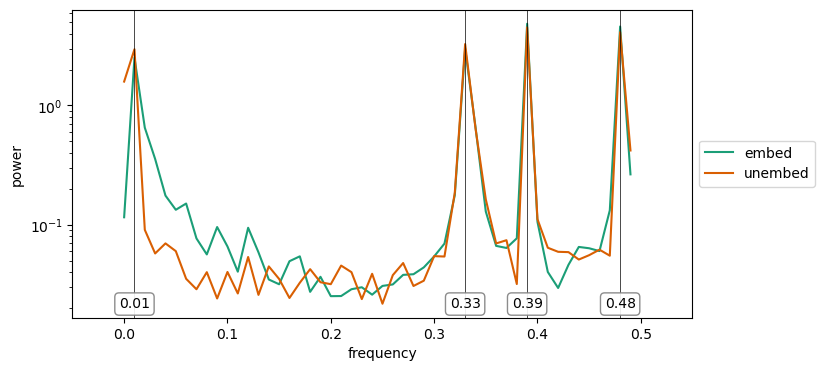

In [16]:
fig, ax = plt.subplots(1,1, figsize=(8, 4))
ax.set_prop_cycle('color', palettable.colorbrewer.qualitative.Dark2_8.mpl_colors)

freqs = np.fft.fftfreq(100)
fft = np.fft.fft(tfm.W_E.detach().cpu().numpy()[:100,:], axis=0)
power = np.conj(fft)*fft
plt.semilogy(freqs[freqs >=0], np.mean(power, axis=1)[freqs >=0], label='embed')

fft = np.fft.fft(tfm.W_U.detach().cpu().numpy()[:,:100], axis=1)
power = np.conj(fft)*fft
plt.semilogy(freqs[freqs >=0], np.mean(power, axis=0)[freqs >=0], label='unembed')
plt.xlabel('frequency')
plt.ylabel('power')
plt.xlim(-0.05, 0.55)

plt.axvline(freqs[freqs >= 0][1], c='k', lw=0.5)
plt.axvline(freqs[freqs >= 0][-2], c='k', lw=0.5)
plt.axvline(freqs[freqs >= 0][-11], c='k', lw=0.5)
plt.axvline(freqs[freqs >= 0][-17], c='k', lw=0.5)

bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
ax.text(freqs[freqs >= 0][1],   2e-2, f'{freqs[freqs >= 0][1]:.2f}', ha='center', bbox=bbox_props)
ax.text(freqs[freqs >= 0][-2],  2e-2, f'{freqs[freqs >= 0][-2]:.2f}', ha='center', bbox=bbox_props)
ax.text(freqs[freqs >= 0][-11], 2e-2, f'{freqs[freqs >= 0][-11]:.2f}', ha='center', bbox=bbox_props)
ax.text(freqs[freqs >= 0][-17], 2e-2, f'{freqs[freqs >= 0][-17]:.2f}', ha='center', bbox=bbox_props)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig(figdir/'embed_unembed_power.png', dpi=300, bbox_inches='tight')

# Directions in unembedding space

Get the angle between each token's unembedding vector

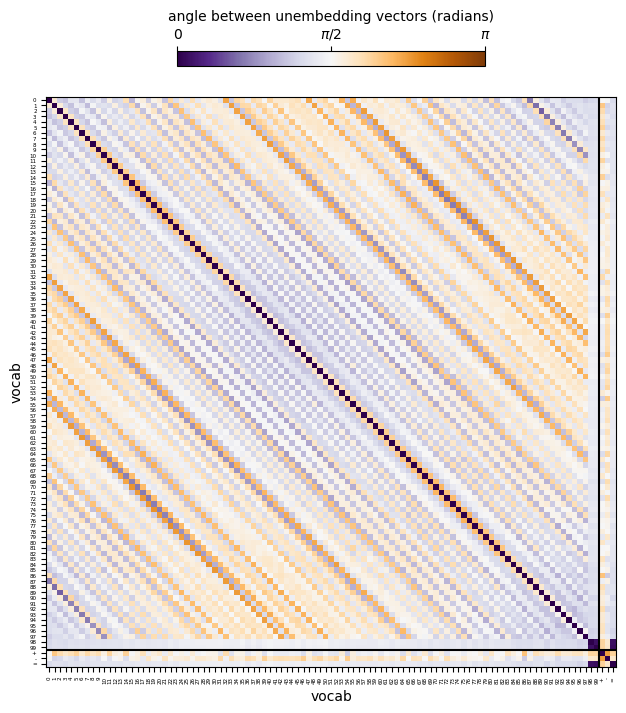

In [17]:
fig,ax = plt.subplots(1,1, figsize=(8, 8))
vocab = [s.replace(' ', '_') for s in tokenizer.convert_ids_to_tokens(range(d_vocab))]
W_U = tfm.W_U.cpu().detach().numpy()
angles = np.zeros((d_vocab,d_vocab))
for i in range(d_vocab):
    for j in range(d_vocab):
        if i == j:
            angles[i,j] = 0
        else:
            angles[i,j] = np.arccos(np.sum(W_U[:,i]*W_U[:,j])/(np.sqrt(np.sum(W_U[:,i]**2)) * np.sqrt(np.sum(W_U[:,j]**2))))
pic = ax.imshow(angles, cmap='PuOr_r', vmin=0, vmax=np.pi)
cbar = plt.colorbar(pic, orientation='horizontal', location='top', fraction=0.025)
cbar.set_label('angle between unembedding vectors (radians)')
cbar.set_ticks((0, np.pi/2, np.pi))
cbar.set_ticklabels((0, r'$\pi/2$', r'$\pi$'))
plt.ylabel('vocab')
plt.xlabel('vocab')
plt.axhline(99.5, c='k')
plt.axvline(99.5, c='k')
ax.set_yticks(range(d_vocab));
ax.set_xticks(range(d_vocab));
ax.set_xticklabels(vocab, rotation='vertical', fontsize=4);
ax.set_yticklabels(vocab, fontsize=4);
fig.savefig(figdir/'unembedding_angles.png', dpi=300, bbox_inches='tight')

# Attention Patterns

In [18]:
prob = np.random.randint(0, int(1e4))
toks = data.tok[prob]
tokens = tfm.to_str_tokens(toks)

attn_patt = cache['pattern', 0, 'attn'][prob]

html = cv.attention.attention_patterns(
    tokens=tokens,
    attention=attn_patt,
)

display(html)

# What information can be neglected?

Short answer: We can neglect all the embedding information in the [1] (second) position of the residual stream, and the positional and token embeddings are identical in the [3] (4th) position.

## Can we neglect the embeddings in the second and fourth positions of the residual stream?

In [19]:
print(cache)

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post']


In [20]:
def embed_ablation_hook(
    residual_stream: Float[Tensor, "batch seq d_model"],
    hook: HookPoint,
    indices_to_ablate: list
) -> Float[Tensor, "batch seq d_model"]:
    residual_stream[:,indices_to_ablate,:] *= 0


ablate_pos_1 = functools.partial(embed_ablation_hook, indices_to_ablate=[1,])
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("resid_pre", 0), ablate_pos_1)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('Ablating [1,]')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

ablate_pos_13 = functools.partial(embed_ablation_hook, indices_to_ablate=[1,3])
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("resid_pre", 0), ablate_pos_13)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('\nAblating [1,3]')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

ablate_pos_134 = functools.partial(embed_ablation_hook, indices_to_ablate=[1,3,4])
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("resid_pre", 0), ablate_pos_134)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('\nAblating [1,3,4]')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

Ablating [1,]
Original loss: [0.06826338 0.01807366], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.07016374 0.01859059], Ablated acc: [98.49 99.94]%

Ablating [1,3]
Original loss: [0.06826338 0.01807366], Original acc: [98.549995 99.94    ]%
Ablated loss: [4.079229   0.03033224], Ablated acc: [19.57     99.659996]%

Ablating [1,3,4]
Original loss: [0.06826338 0.01807366], Original acc: [98.549995 99.94    ]%
Ablated loss: [4.079229  6.6714935], Ablated acc: [19.57       1.4499999]%


Is it the positional embeddings or the token embeddings that matter for performance?

### Positional Embed ablations

### Function definitions

In [21]:
def posembed_ablation_hook(
    embedding: Float[Tensor, "batch seq d_model"],
    hook: HookPoint,
    indices_to_ablate: list
) -> Float[Tensor, "batch seq d_model"]:
    embedding[:,indices_to_ablate,:] *= 0


ablate_pos_1 = functools.partial(posembed_ablation_hook, indices_to_ablate=[1,])
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("pos_embed"), ablate_pos_1)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('Ablating [1,]')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

ablate_pos_13 = functools.partial(posembed_ablation_hook, indices_to_ablate=[1,3])
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("pos_embed"), ablate_pos_13)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('\nAblating [1,3]')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

ablate_pos_134 = functools.partial(posembed_ablation_hook, indices_to_ablate=[1,3,4])
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("pos_embed"), ablate_pos_134)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('\nAblating [1,3,4]')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

ablate_pos_02 = functools.partial(posembed_ablation_hook, indices_to_ablate=[0,2])
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("pos_embed"), ablate_pos_02)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('\nAblating [0,2]')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

ablate_pos_0123 = functools.partial(posembed_ablation_hook, indices_to_ablate=[0,1,2,3])
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("pos_embed"), ablate_pos_0123)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('\nAblating [0,1,2,3]')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

Ablating [1,]
Original loss: [0.06826338 0.01807366], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.06969359 0.01803973], Ablated acc: [98.439995 99.94    ]%

Ablating [1,3]
Original loss: [0.06826338 0.01807366], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.11612064 0.01793016], Ablated acc: [97.479996 99.94    ]%

Ablating [1,3,4]
Original loss: [0.06826338 0.01807366], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.11612064 0.28290862], Ablated acc: [97.479996 92.659996]%

Ablating [0,2]
Original loss: [0.06826338 0.01807366], Original acc: [98.549995 99.94    ]%
Ablated loss: [7.307456 6.042138], Ablated acc: [49.579998 16.33    ]%

Ablating [0,1,2,3]
Original loss: [0.06826338 0.01807366], Original acc: [98.549995 99.94    ]%
Ablated loss: [5.994215  6.9871125], Ablated acc: [44.05 12.  ]%


### Token Embed ablations

In [22]:
def tokembed_ablation_hook(
    embedding: Float[Tensor, "batch seq d_model"],
    hook: HookPoint,
    indices_to_ablate: list
) -> Float[Tensor, "batch seq d_model"]:
    embedding[:,indices_to_ablate,:] *= 0


ablate_pos_1 = functools.partial(tokembed_ablation_hook, indices_to_ablate=[1,])
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("embed"), ablate_pos_1)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('Ablating [1,]')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

ablate_pos_13 = functools.partial(tokembed_ablation_hook, indices_to_ablate=[1,3])
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("embed"), ablate_pos_13)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('\nAblating [1,3]')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

ablate_pos_134 = functools.partial(tokembed_ablation_hook, indices_to_ablate=[1,3,4])
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("embed"), ablate_pos_134)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('\nAblating [1,3,4]')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

ablate_pos_02 = functools.partial(tokembed_ablation_hook, indices_to_ablate=[0,2])
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("embed"), ablate_pos_02)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('\nAblating [0,2]')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

ablate_pos_0123 = functools.partial(tokembed_ablation_hook, indices_to_ablate=[0,1,2,3])
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("embed"), ablate_pos_0123)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('\nAblating [0,1,2,3]')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

Ablating [1,]
Original loss: [0.06826338 0.01807366], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.07121137 0.01803907], Ablated acc: [98.5  99.94]%

Ablating [1,3]
Original loss: [0.06826338 0.01807366], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.11180839 0.01794066], Ablated acc: [97.57 99.94]%

Ablating [1,3,4]
Original loss: [0.06826338 0.01807366], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.11180839 7.2626295 ], Ablated acc: [97.57 26.  ]%

Ablating [0,2]
Original loss: [0.06826338 0.01807366], Original acc: [98.549995 99.94    ]%
Ablated loss: [ 3.2273002 43.11052  ], Ablated acc: [49.5  0. ]%

Ablating [0,1,2,3]
Original loss: [0.06826338 0.01807366], Original acc: [98.549995 99.94    ]%
Ablated loss: [ 5.8421106 43.77924  ], Ablated acc: [49.5  0. ]%


### Are the positional and token embeddings of the = the same? -> Yes.

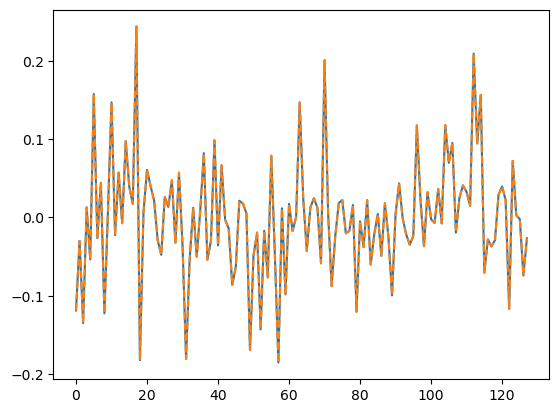

In [23]:
plt.plot(W_E[-1,:].detach().numpy())
plt.plot(W_pos[3,:].detach().numpy(), ls='--')

# Neuron Activations

### The simple sin/cos based transform makes this all much easier to reason about.

In [24]:
def make_fourier_basis(p: int) -> Tuple[Tensor, List[str]]:
    '''
    Returns a pair `fourier_basis, fourier_basis_names`, where `fourier_basis` is
    a `(p, p)` tensor whose rows are Fourier components and `fourier_basis_names`
    is a list of length `p` containing the names of the Fourier components (e.g.
    `["const", "cos 1", "sin 1", ...]`). You may assume that `p` is odd.
    '''
    #I'm just copy+pasting the solution here; I know numpy does this well, too.
    fourier_basis = t.ones(p, p)
    fourier_basis_names = ['Const']
    for i in range(1, p // 2):
        # Define each of the cos and sin terms
        fourier_basis[2*i-1] = t.cos(2*t.pi*t.arange(p)*i/p)
        fourier_basis[2*i] = t.sin(2*t.pi*t.arange(p)*i/p)
        fourier_basis_names.extend([f'cos {i}', f'sin {i}'])
    # Normalize vectors, and return them
    fourier_basis /= fourier_basis.norm(dim=1, keepdim=True)
    return fourier_basis.to(device), fourier_basis_names

fourier_basis, fourier_basis_names = make_fourier_basis(100)

def fft1d(x: t.Tensor) -> t.Tensor:
    '''
    Returns the 1D Fourier transform of `x`,
    which can be a vector or a batch of vectors.

    x.shape = (..., p)
    '''
    #again, just np.fft.fft()
    return x @ fourier_basis.T

def fourier_2d_basis_term(i: int, j: int) -> Float[Tensor, "p p"]:
    '''
    Returns the 2D Fourier basis term corresponding to the outer product of the
    `i`-th component of the 1D Fourier basis in the `x` direction and the `j`-th
    component of the 1D Fourier basis in the `y` direction.

    Returns a 2D tensor of length `(p, p)`.
    '''
    return fourier_basis[i][:,None]*fourier_basis[j][None,:]

def fft2d(tensor: t.Tensor) -> t.Tensor:
    '''
    Retuns the components of `tensor` in the 2D Fourier basis.

    Asumes that the input has shape `(p, p, ...)`, where the
    last dimensions (if present) are the batch dims.
    Output has the same shape as the input.
    '''
    return einops.einsum(
        tensor, fourier_basis, fourier_basis,
        "px py ..., i px, j py -> i j ..."
    )



In [41]:
attn_mat = cache['pattern', 0, 'attn'][:,:,3,:]
neuron_acts_post = cache['blocks.0.mlp.hook_pre'][:,3]
neuron_acts_pre = cache['blocks.0.mlp.hook_post'][:,3]
print(neuron_acts_post.shape)
neuron_acts_post_sq = einops.rearrange(neuron_acts_post, "(x y) d_mlp -> x y d_mlp", x=100)
neuron_acts_pre_sq = einops.rearrange(neuron_acts_pre, "(x y) d_mlp -> x y d_mlp", x=100)

torch.Size([10000, 512])


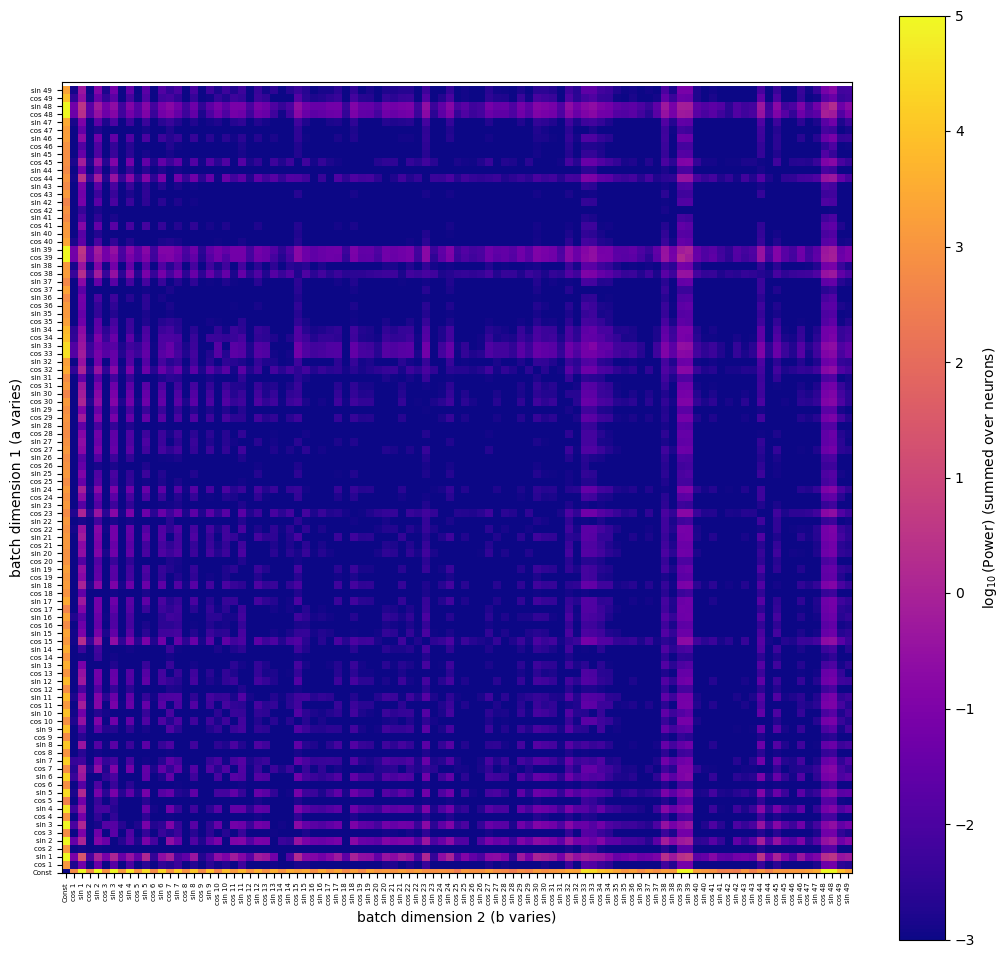

In [77]:
neuron_acts_centered = neuron_acts_post_sq - neuron_acts_post_sq.mean((0,1),keepdim=True)
# neuron_acts_centered = neuron_acts_pre_sq - neuron_acts_pre_sq.mean((0,1),keepdim=True)
ft_acts = fft2d(neuron_acts_centered)


kfreqs = t.Tensor([ 1, 33, 39, 48]).to(t.int)


square_of_all_terms = einops.reduce(
        ft_acts.pow(2),
        "x_coeff y_coeff neuron -> neuron",
        "sum"
    )
square_of_all_terms[square_of_all_terms < 1e-16] = 1e-16

power = (ft_acts**2).sum(axis=-1)

# power = (ft_acts**2/square_of_all_terms[None,None,:]).sum(axis=-1)

# print(f'power before {power.sum():.3e}')
# power[0,:] = 1e-8
# power[:,0] = 1e-8
# print(f'power after like-terms {power.sum():.3e}')
# for f in kfreqs:
#     power[2*f-1,:] = 1e-8
#     power[2*f,:] = 1e-8
#     power[:,2*f-1] = 1e-8
#     power[:,2*f] = 1e-8
# print(f'power after {power.sum():.3e}')
# print(1.058e6/3.438e6)

fig, ax = plt.subplots(1, 1, figsize=(12,12))
axs = [ax,]
plot = axs[0].imshow(np.log10(power[:-1,:-1]), cmap='plasma', vmin=-3, vmax=5)
cbar = plt.colorbar(plot, fraction=0.1)
cbar.set_label(r'$\log_{10}(\rm{Power})$ (summed over neurons)')
axs[0].set_ylim(0, 99)
axs[0].set_yticks(range(99));
axs[0].set_yticklabels(fourier_basis_names, fontsize=5);
axs[0].set_xticks(range(99));
axs[0].set_xticklabels(fourier_basis_names, fontsize=5, rotation='vertical');
axs[0].set_ylabel('batch dimension 1 (a varies)')
axs[0].set_xlabel('batch dimension 2 (b varies)')
fig.savefig(figdir/'neuron_post_power_sum.png', dpi=300)

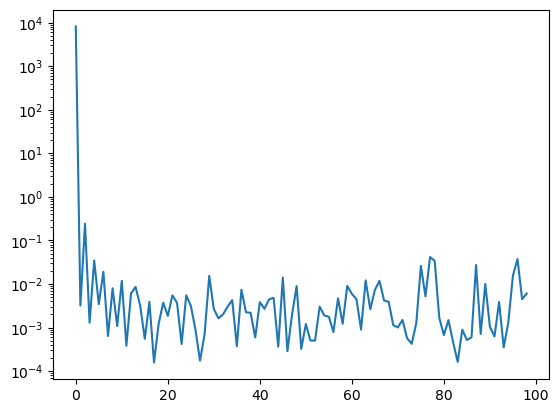

In [56]:
plt.semilogy(power[-3,:-1])

In [27]:

#note fourier transform has positive and negative frequencies.
# e^{\pm ix} = cos x \pm i sin x
# so e^{+ix} + e^{-ix} = 2*cos(x)
# Choose a particular frequency, and get the corresponding cosine basis vector
k = 33
vec = t.cos(2*np.pi*k/100 * t.arange(100))

pos_idx = np.argmin(np.abs(freq - k/100))
neg_idx = np.argmin(np.abs(freq + k/100))

# Get ReLU function values
relu_func_values = F.relu(0.5 * (100 ** -0.5) + vec[None, :] + vec[:, None])

# Get terms we'll be using to approximate it
# Note we're including the constant term here
data = t.stack([t.ones(100,100)/100, 2*t.cos(2*np.pi*k/100 * t.arange(100))[:,None]*t.ones(100)[None,:]/100,
                2*t.cos(2*np.pi*k/100 * t.arange(100))[None,:]*t.ones(100)[:,None]/100,
                4*t.cos(2*np.pi*k/100 * t.arange(100))[:,None]*t.cos(2*np.pi*k/100 * t.arange(100))[None,:]/100], dim=-1)

# Reshape, and convert to numpy
data = utils.to_numpy(data.reshape(100*100, 4))
relu_func_values = utils.to_numpy(relu_func_values.flatten())

# Fit a linear model (we don't need intercept because we have const Fourier basis term)
reg = LinearRegression(fit_intercept=False).fit(data, relu_func_values)
coefs = reg.coef_
eqn = "ReLU(0.5 + cos(wx) + cos(wy) ≈ {:.3f}*const + {:.3f}*cos(wx) + {:.3f}*cos(wy) + {:.3f}*cos(wx)cos(wy)".format(*coefs)
r2 = reg.score(data, relu_func_values)
print(eqn)
print("")
print(f"r2: {r2:.3f}")

# Run the regression again, but without the quadratic term
data = data[:, :3]
reg = LinearRegression().fit(data, relu_func_values)
coefs = reg.coef_
bias = reg.intercept_
r2 = reg.score(data, relu_func_values)
print(f"r2 (no quadratic term): {r2:.3f}")

NameError: name 'freq' is not defined

In [125]:
def arrange_by_2d_freqs(tensor):
    '''
    Takes a tensor of shape (p, p, ...) and returns a tensor of shape
    (p//2 - 1, 3, 3, ...) representing the Fourier coefficients sorted by
    frequency (each slice contains const, linear and quadratic terms).

    In other words, if the first two dimensions of the original tensor
    correspond to indexing by 2D Fourier frequencies as follows:

        1           cos(w_1*x)            sin(w_1*x)           ...
        cos(w_1*y)  cos(w_1*x)cos(w_1*y)  sin(w_1*x)cos(w_1*y) ...
        sin(w_1*y)  cos(w_1*x)sin(w_1*y)  sin(w_1*x)sin(w_1*y) ...
        cos(w_2*y)  cos(w_1*x)cos(w_2*y)  sin(w_1*x)cos(w_2*y) ...
        ...

    Then the (k-1)-th slice of the new tensor are the terms corresponding to
    the following 2D Fourier frequencies:

        1           cos(w_k*x)            sin(w_k*x)           ...
        cos(w_k*y)  cos(w_k*x)cos(w_k*y)  sin(w_k*x)cos(w_k*y) ...
        sin(w_k*y)  cos(w_k*x)sin(w_k*y)  sin(w_k*x)sin(w_k*y) ...

    for k = 1, 2, ..., p//2.

    Note we omit the constant term, i.e. the 0th slice has frequency k=1.
    '''
    idx_2d_y_all = []
    idx_2d_x_all = []
    for freq in range(1, 100//2):
        idx_1d = [0, 2*freq-1, 2*freq]
        idx_2d_x_all.append([idx_1d for _ in range(3)])
        idx_2d_y_all.append([[i]*3 for i in idx_1d])
    # print(idx_2d_x_all)
    return tensor[idx_2d_y_all, idx_2d_x_all]


def find_neuron_freqs(
    fourier_neuron_acts: Float[Tensor, "p p d_mlp"],
    top_k : int = 1
) -> Tuple[Float[Tensor, "d_mlp"], Float[Tensor, "d_mlp"]]:
    '''
    Returns the tensors `neuron_freqs` and `neuron_frac_explained`,
    containing the frequencies that explain the most variance of each
    neuron and the fraction of variance explained, respectively.
    '''
    fourier_neuron_acts_by_freq = arrange_by_2d_freqs(fourier_neuron_acts)
    assert fourier_neuron_acts_by_freq.shape == (100//2-1, 3, 3, d_mlp)

    # Sum squares of all frequency coeffs, for each neuron
    square_of_all_terms = einops.reduce(
        fourier_neuron_acts.pow(2),
        "x_coeff y_coeff neuron -> neuron",
        "sum"
    )

    # Sum squares just corresponding to const+linear+quadratic terms,
    # for each frequency, for each neuron
    square_of_each_freq = einops.reduce(
        fourier_neuron_acts_by_freq.pow(2),
        "freq x_coeff y_coeff neuron -> freq neuron",
        "sum"
    )

    if top_k == 1:
        # Find the freq explaining most variance for each neuron
        # (and the fraction of variance explained)
        neuron_variance_explained, neuron_freqs = square_of_each_freq.max(0)
        neuron_frac_explained = neuron_variance_explained / square_of_all_terms
    
        # The actual frequencies count up from k=1, not 0!
        neuron_freqs += 1
        return neuron_freqs, neuron_frac_explained
    else:
        # Find the freq explaining most variance for each neuron
        # (and the fraction of variance explained)
        neuron_variance_explained, neuron_freqs = square_of_each_freq.topk(top_k,dim=0)
        neuron_frac_explained = neuron_variance_explained.sum(dim=0) / square_of_all_terms
    
        # The actual frequencies count up from k=1, not 0!
        neuron_freqs += 1
        return neuron_freqs, neuron_frac_explained
        
        

neuron_freqs, neuron_frac_explained = find_neuron_freqs(t.Tensor(ft_acts), top_k=1)
key_freqs, neuron_freq_counts = t.unique(t.sort(neuron_freqs).values, return_counts=True)#, dim=1)

print('key frequencies: ', key_freqs)

key frequencies:  tensor([ 1, 33, 39, 48])


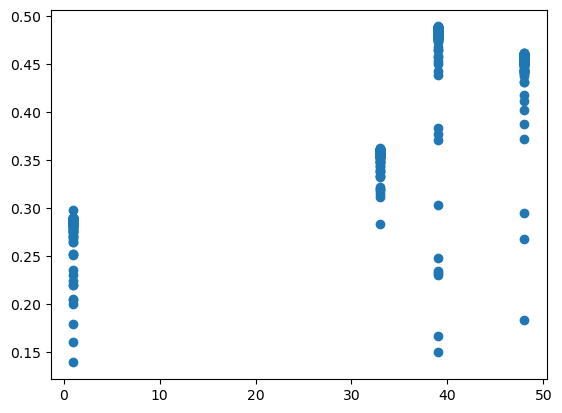

In [79]:
plt.scatter(neuron_freqs, neuron_frac_explained)

Only up to half of the power is contained in these 'like' terms (w_k with w_k). Turns out this half of the power is entirely in terms like cos(w_k) or sin(w_k). 

What happens if, for each neuron, we sample all the power in all the terms of its maximum frequency -- what happens then?

Text(0, 0.5, 'fraction of neuron power in dominant frequency')

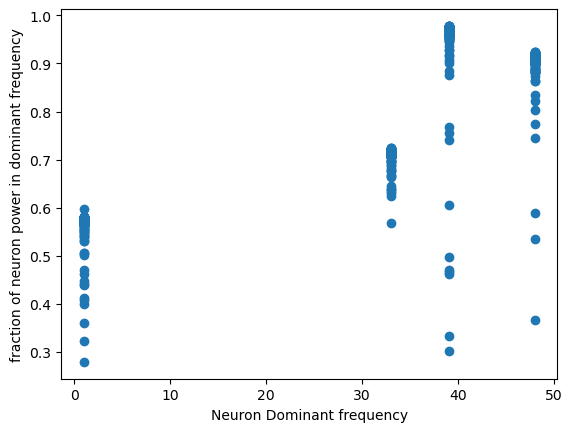

In [88]:
def check_neuron_power(
    fourier_neuron_acts: Float[Tensor, "p p d_mlp"],
    neuron_freqs: Int[Tensor, "d_mlp"],
) -> Tuple[Float[Tensor, "d_mlp"], Float[Tensor, "d_mlp"]]:
    # Sum squares of all frequency coeffs, for each neuron
    square_of_all_terms = einops.reduce(
        fourier_neuron_acts.pow(2),
        "x_coeff y_coeff neuron -> neuron",
        "sum"
    )
    pow = fourier_neuron_acts.pow(2)

    neuron_pow = t.zeros(neuron_freqs.shape[0])
    for i,f in enumerate(neuron_freqs):
        for j in (2*f-1, 2*f):
            neuron_pow[i] += pow[j,:,i].sum()
            neuron_pow[i] += pow[:,j,i].sum()
            for k in (2*f-1, 2*f):
                neuron_pow[i] -= pow[j,k,i] #fix the four places where the rows/columns overlap

    return neuron_pow / square_of_all_terms
frac_explained = check_neuron_power(t.Tensor(ft_acts), neuron_freqs)

plt.scatter(neuron_freqs, frac_explained)
plt.xlabel("Neuron Dominant frequency")
plt.ylabel("fraction of neuron power in dominant frequency")

### Ablate unimportant frequencies for each head
Now we're going to write a hook to fourier transform the data, remove all frequencies except the most important one for each head, then transform back into 

In [126]:
freqs = np.fft.fftfreq(100)
key_freq_inds = []
for f1 in key_freqs:
    for i, f2 in enumerate(freqs):
        if np.abs(f2) == f1/100:
            key_freq_inds.append(i)
# neuron_freq_inds = t.Tensor([[i for i, f1 in enumerate(freqs) if np.abs(f1) == f2/100] for f2 in neuron_freqs]).to(t.int)
print(key_freq_inds)

[1, 99, 33, 67, 39, 61, 48, 52]


In [131]:
def crossfreq_ablation_hook(
    neurons: Float[Tensor, "batch seq d_mlp"],
    hook: HookPoint,
    seq_ind: int = -2
) -> Float[Tensor, "batch seq d_mlp"]:
    
    neuron_acts_post_sq = einops.rearrange(neurons[:,seq_ind,:], "(x y) d_mlp -> x y d_mlp", x=100)
    ft = np.fft.fft2(neuron_acts_post_sq.detach().numpy(), axes=[0,1])
    new_ft = np.zeros_like(ft)
    new_ft[0,:,:] = ft[0,:,:]
    new_ft[:,0,:] = ft[:,0,:]
    # for k in key_freq_inds:
    #     new_ft[0,k,:] = ft[0,k,:]
    #     new_ft[k,0,:] = ft[k,0,:]
    acts = np.fft.ifft2(new_ft, axes=[0,1]).real
    neuron_acts_post_sq[:] = t.Tensor(acts)
    neurons[:,seq_ind,:] = einops.rearrange(neuron_acts_post_sq, "x y d_mlp -> (x y) d_mlp")


ablate_freqs = functools.partial(crossfreq_ablation_hook, seq_ind=-3)
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.mlp.hook_pre"), ablate_freqs)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('Ablating seq_ind -3')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

ablate_freqs = functools.partial(crossfreq_ablation_hook, seq_ind=-2)
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.mlp.hook_pre"), ablate_freqs)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('Ablating seq_ind -2')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")


Ablating seq_ind -3
Original loss: [0.06826338 0.01807366], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.07320004 0.01807366], Ablated acc: [98.47 99.94]%
Ablating seq_ind -2
Original loss: [0.06826338 0.01807366], Original acc: [98.549995 99.94    ]%
Ablated loss: [0.06826338 5.3479557 ], Ablated acc: [98.549995 16.57    ]%


In [124]:
def simplefreq_ablation_hook(
    neurons: Float[Tensor, "batch seq d_mlp"],
    hook: HookPoint,
    seq_ind: int = -2
) -> Float[Tensor, "batch seq d_mlp"]:
    
    neuron_acts_post_sq = einops.rearrange(neurons[:,seq_ind,:], "(x y) d_mlp -> x y d_mlp", x=100)
    ft = np.fft.fft2(neuron_acts_post_sq.detach().numpy(), axes=[0,1])
    ft[0,:,:] = 0
    ft[:,0,:] = 0
    acts = np.fft.ifft2(ft, axes=[0,1]).real
    neuron_acts_post_sq[:] = t.Tensor(acts)
    neurons[:,seq_ind,:] = einops.rearrange(neuron_acts_post_sq, "x y d_mlp -> (x y) d_mlp")


ablate_freqs = functools.partial(simplefreq_ablation_hook, seq_ind=-3)
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.mlp.hook_pre"), ablate_freqs)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('Ablating seq_ind -3')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")

ablate_freqs = functools.partial(simplefreq_ablation_hook, seq_ind=-2)
ablated_logits = tfm.run_with_hooks(data.tok, fwd_hooks=[
                (utils.get_act_name("blocks.0.mlp.hook_pre"), ablate_freqs)
            ])
ablated_loss = get_loss(ablated_logits, data.tok, meandim=0) #loss by digit
ablated_acc  = get_accuracy(ablated_logits, data.tok, meandim=0)

print('Ablating seq_ind -2')
print(f"Original loss: {original_loss.detach().numpy()}, Original acc: {100*original_acc.detach().numpy()}%")
print(f"Ablated loss: {ablated_loss.detach().numpy()}, Ablated acc: {100*ablated_acc.detach().numpy()}%")


Ablating seq_ind -3
Original loss: [0.06826338 0.01807366], Original acc: [98.549995 99.94    ]%
Ablated loss: [3.2895625  0.01807366], Ablated acc: [85.32 99.94]%
Ablating seq_ind -2
Original loss: [0.06826338 0.01807366], Original acc: [98.549995 99.94    ]%
Ablated loss: [ 0.06826338 10.379587  ], Ablated acc: [98.549995  1.48    ]%


# Important matrices

In [ ]:
W_logit = einops.einsum(tfm.W_out, tfm.W_U, "d_mlp d_model, d_model d_vocab -> d_mlp d_vocab")
W_neur = einops.einsum(W_E, W_V, W_O, W_in, "d_vocab d_model, n_head d_model d_head, n_head d_head d_model, d_model d_mlp -> n_head d_vocab d_mlp")
t3 = cache['embed'][0,3,:]
W_attn = einops.einsum(t3, W_Q, W_K, W_E, "d_model, n_head d_model d_head, n_head d_model d_head, d_vocab d_model -> n_head d_vocab") / np.sqrt(cfg.d_head)
print(W_logit.shape, W_neur.shape, W_attn.shape)